In [5]:
import pyspark.sql.functions as F
import pyspark.pandas as ps
import matplotlib.pyplot as plt
import seaborn as sns


/home/dat/venv/lib/python3.12/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [ ]:
from pyspark.sql import SparkSession

# Kh·ªüi t·∫°o SparkSession
spark = SparkSession.builder \
    .appName("Read HDFS CSV") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .getOrCreate()

# ƒê·ªçc d·ªØ li·ªáu tr√™n HDFS
df = spark.read.csv("hdfs://localhost:9000/user/dat/csv_output_final/csv_output_final.csv", header=True, inferSchema=True)

# Ki·ªÉm tra
df.printSchema()
df.show(5)

df.count() 



root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+

82487472

In [ ]:
# Ki·ªÉm tra c√°c gi√° tr·ªã null
from pyspark.sql.functions import col
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|                   0|                    0|        5586198|            0|   5586198|           5586198|           0|           0|           0|          0|    0|      0|         

In [ ]:
# Thay th·∫ø c√°c gi√° tr·ªã null b·∫±ng 0
df = df.fillna({
    "Airport_fee": 0.0,
    "congestion_surcharge": 0.0
})

In [ ]:
df = df.drop("store_and_fwd_flag") # B·ªè c·ªôt gi√° tr·ªã l·ªói 
from pyspark.sql.functions import col, count

# Nh√≥m l·∫°i theo c·ªôt RatecodeID
mode_ratecode = df.groupBy("RatecodeID").count().orderBy("count", ascending=False).first()[0] 

# Thay th·∫ø c√°c gi√° tr·ªã null 
df = df.fillna({"RatecodeID": mode_ratecode})

In [ ]:
# Thay th·∫ø c√°c gi√° tr·ªã null b·∫±ng gi√° tr·ªã trung b√¨nh
from pyspark.sql.functions import avg
avg_passenger = int(df.select(avg("passenger_count")).first()[0])
df = df.fillna({"passenger_count": avg_passenger})
df = df.withColumn("passenger_count", col("passenger_count").cast("int"))



In [ ]:
# Ki·ªÉm tra s·ªë l∆∞·ª£ng gi√° tr·ªã null c√≥ trong c·ªôt
from pyspark.sql.functions import count, when, col
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|                   0|                    0|              0|            0|         0|           0|           0|           0|          0|    0|      0|         0|           0|                    0|           0|                   0|     

In [ ]:
from pyspark.sql import functions as F

# X·ª≠ l√Ω datetime v√† chuy·ªÉn ki·ªÉu d·ªØ li·ªáu
df1 = df.withColumn("tpep_pickup_datetime", F.to_timestamp("tpep_pickup_datetime")) \
        .withColumn("year", F.year("tpep_pickup_datetime")) \
        .withColumn("month", F.month("tpep_pickup_datetime")) \
        .withColumn("total_amount", F.col("total_amount").cast("float"))

# T√≠nh t·ªïng doanh thu theo nƒÉm v√† th√°ng
df_revenue_by_month = df1.groupBy("year", "month") \
    .agg(F.sum("total_amount").alias("monthly_revenue")) \
    .orderBy("year", "month")

df_revenue_by_month.show()


+----+-----+--------------------+
|year|month|     monthly_revenue|
+----+-----+--------------------+
|2001|    1|   337.6600065231323|
|2002|   12|   930.5700197219849|
|2003|    1|  454.08000564575195|
|2008|   12|  1839.1100254058838|
|2009|    1|  1062.6500091552734|
|2014|   11|  52.380001068115234|
|2022|   10|   760.4900035858154|
|2022|   12|   658.2300033569336|
|2023|    1| 8.286359431076753E7|
|2023|    2| 7.838160060513437E7|
|2023|    3|  9.46340278937267E7|
|2023|    4| 9.295684332478693E7|
|2023|    5| 1.017660215005421E8|
|2023|    6| 9.613736043698683E7|
|2023|    7| 8.305003049120525E7|
|2023|    8| 8.085130961235107E7|
|2023|    9| 8.478139689532411E7|
|2023|   10|1.0274907785624012E8|
|2023|   11| 9.583622721895497E7|
|2023|   12| 9.637144780949754E7|
+----+-----+--------------------+
only showing top 20 rows



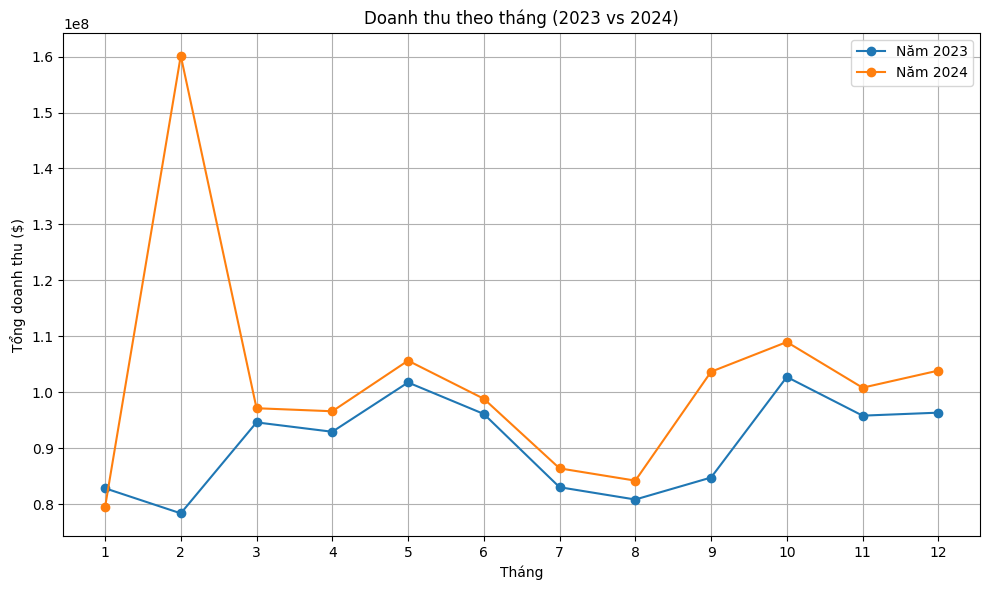

In [16]:
df2 = df.withColumn("tpep_pickup_datetime", F.to_timestamp("tpep_pickup_datetime")) \
        .withColumn("year", F.year("tpep_pickup_datetime")) \
        .withColumn("month", F.month("tpep_pickup_datetime")) \
        .withColumn("total_amount", F.col("total_amount").cast("float"))

df_filtered = df2.filter((F.col("year") == 2023) | (F.col("year") == 2024))

df_grouped1 = df_filtered.groupBy("year", "month") \
    .agg(F.sum("total_amount").alias("monthly_revenue")) \
    .orderBy("year", "month")

pdf1 = df_grouped1.toPandas()

plt.figure(figsize=(10, 6))
for year in [2023, 2024]:
    df_year = pdf1[pdf1['year'] == year]
    plt.plot(df_year['month'], df_year['monthly_revenue'], marker='o', label=f"NƒÉm {year}")

plt.title("Doanh thu theo th√°ng (2023 vs 2024)")
plt.xlabel("Th√°ng")
plt.ylabel("T·ªïng doanh thu ($)")
plt.xticks(range(1, 13))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


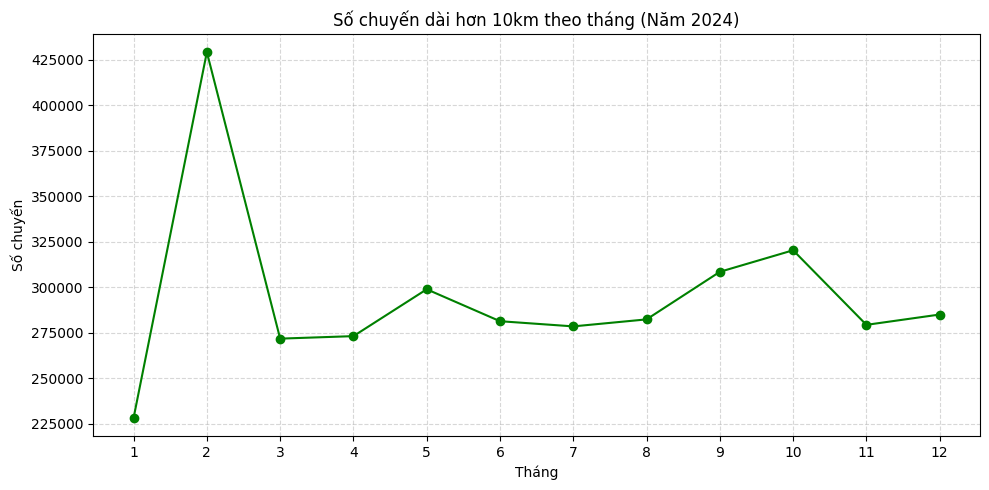

In [17]:
df_with_time = df.withColumn("tpep_pickup_datetime", F.to_timestamp("tpep_pickup_datetime")) \
                 .withColumn("month", F.month("tpep_pickup_datetime")) \
                 .withColumn("year", F.year("tpep_pickup_datetime"))

df_long_trips_2024 = df_with_time.filter((df_with_time.trip_distance > 10) & (df_with_time.year == 2024))

df_grouped1 = df_long_trips_2024.groupBy("month").agg(F.count("*").alias("trips_over_10km")).orderBy("month")

results1 = df_grouped1.collect()
months = [row["month"] for row in results1]
trips = [row["trips_over_10km"] for row in results1]

plt.figure(figsize=(10, 5))
plt.plot(months, trips, marker='o', color='green')
plt.title("S·ªë chuy·∫øn d√†i h∆°n 10km theo th√°ng (NƒÉm 2024)")
plt.xlabel("Th√°ng")
plt.ylabel("S·ªë chuy·∫øn")
plt.xticks(range(1, 13))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

df3 = df.withColumn("pickup_datetime", to_timestamp("tpep_pickup_datetime")) \
        .withColumn("pickup_hour", hour("pickup_datetime")) \
        .withColumn("pickup_date", to_date("pickup_datetime")) \
        .withColumn("passenger_count", col("passenger_count").cast("int")) \
        .withColumn("trip_distance", col("trip_distance").cast("float")) \
        .withColumn("PULocationID", col("PULocationID").cast("int")) \
        .withColumn("total_amount", col("total_amount").cast("float")) \
        .withColumn("is_holiday", when(
            (date_format("pickup_date", "MM-dd").isin("01-01", "07-04", "12-25")) | 
            (dayofweek("pickup_date").isin(1, 7)), 1).otherwise(0)) \
        .filter(year("pickup_datetime").isin(2023, 2024)) \
        .dropna(subset=["passenger_count", "trip_distance", "PULocationID", "pickup_hour", "total_amount"])

assembler = VectorAssembler(
    inputCols=["passenger_count", "trip_distance", "PULocationID", "pickup_hour", "is_holiday"],
    outputCol="features"
)
final_df = assembler.transform(df3).select("features", "total_amount")

train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=42)

lr = LinearRegression(featuresCol="features", labelCol="total_amount")
lr_model = lr.fit(train_df)

test_summary = lr_model.evaluate(test_df)

print("Coefficients:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)
print("Test RMSE:", test_summary.rootMeanSquaredError)
print("Test R¬≤:", test_summary.r2)


25/04/12 11:40:10 WARN Instrumentation: [f78e7120] regParam is zero, which might cause numerical instability and overfitting.


üéØ Coefficients: [1.3082893911693234,0.0007787617504345538,-0.040457032302129055,0.06259181387702865,-1.3276619732160069]
üéØ Intercept: 32.481607456070954
üìâ Test RMSE: 85.568912785598
üìà Test R¬≤: 0.0011240347386014538


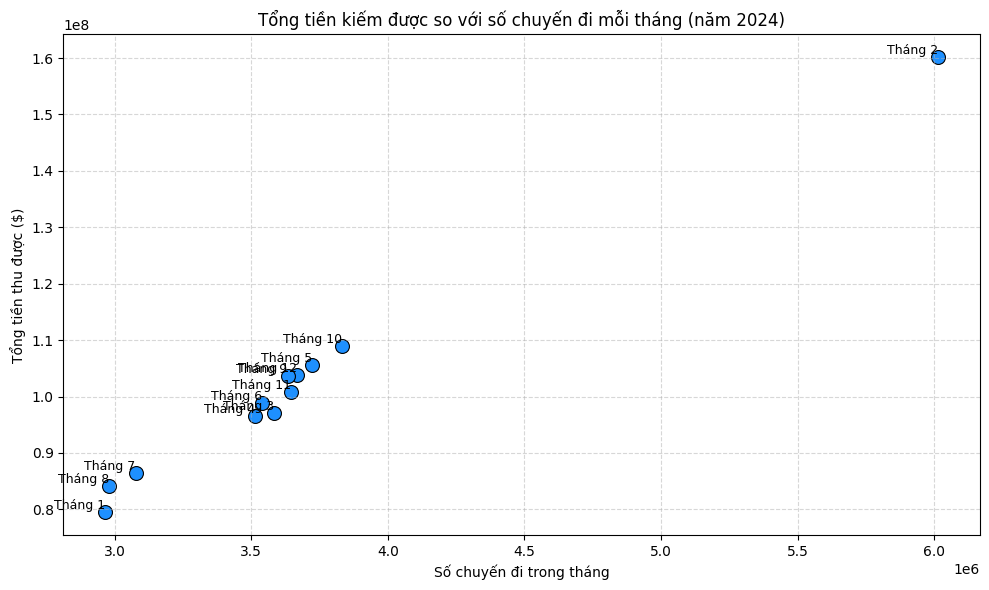

In [27]:
from pyspark.sql.functions import month, year, count, sum

df4 = df3.withColumn("month", month("pickup_datetime"))

df_2024 = df4.filter(year("pickup_datetime") == 2024)

df_agg = df_2024.groupBy("month") \
    .agg(
        count("*").alias("num_trips"),
        sum("total_amount").alias("total_revenue")
    )

df_pd = df_agg.toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(x="num_trips", y="total_revenue", data=df_pd, s=100, color='dodgerblue', edgecolor='black')

for i in range(df_pd.shape[0]):
    plt.text(df_pd["num_trips"][i], df_pd["total_revenue"][i], f'Th√°ng {df_pd["month"][i]}', 
             fontsize=9, ha='right', va='bottom')

plt.title("T·ªïng ti·ªÅn ki·∫øm ƒë∆∞·ª£c so v·ªõi s·ªë chuy·∫øn ƒëi m·ªói th√°ng (nƒÉm 2024)")
plt.xlabel("S·ªë chuy·∫øn ƒëi trong th√°ng")
plt.ylabel("T·ªïng ti·ªÅn thu ƒë∆∞·ª£c ($)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


B·∫£ng gi√° c∆∞·ªõc trung b√¨nh nƒÉm 2023 v√† 2024 theo lo·∫°i ng√†y:
+----+----------+------------------+----------------+
|year|is_holiday|          avg_fare|is_holiday_label|
+----+----------+------------------+----------------+
|2023|         0|28.720176085905155|     Ng√†y th∆∞·ªùng|
|2023|         1|27.780551986981923|         Ng√†y l·ªÖ|
+----+----------+------------------+----------------+

+----+----------+-----------------+----------------+
|year|is_holiday|         avg_fare|is_holiday_label|
+----+----------+-----------------+----------------+
|2024|         0|28.07221901399345|     Ng√†y th∆∞·ªùng|
|2024|         1|26.93737674973189|         Ng√†y l·ªÖ|
+----+----------+-----------------+----------------+



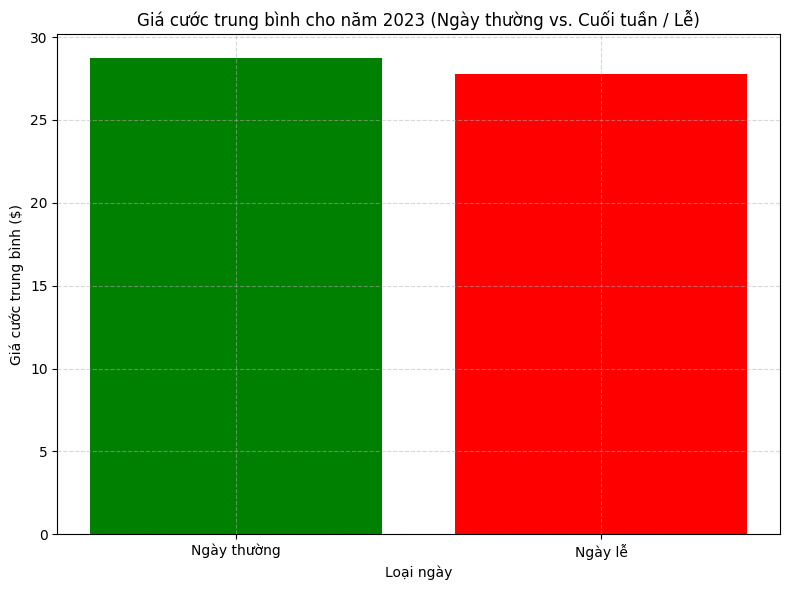

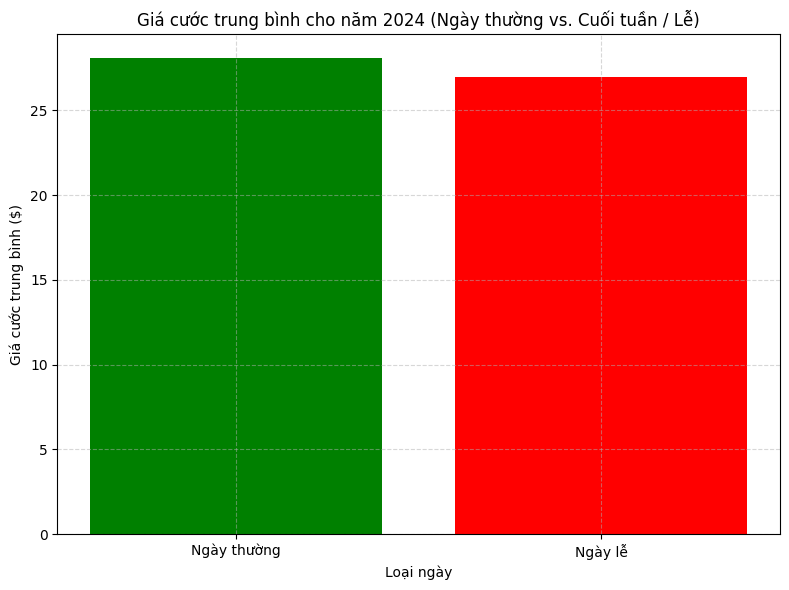

In [42]:
from pyspark.sql.functions import *

df3 = df3.withColumn("year", year("pickup_datetime"))

avg_fare_df = df3.groupBy("year", "is_holiday") \
    .agg(F.avg("total_amount").alias("avg_fare"))

holiday_2023 = avg_fare_df.filter(avg_fare_df["year"] == 2023)
holiday_2024 = avg_fare_df.filter(avg_fare_df["year"] == 2024)

holiday_2023 = holiday_2023.withColumn(
    "is_holiday_label", 
    when(col("is_holiday") == 1, "Ng√†y l·ªÖ").otherwise("Ng√†y th∆∞·ªùng")
)

holiday_2024 = holiday_2024.withColumn(
    "is_holiday_label", 
    when(col("is_holiday") == 1, "Ng√†y l·ªÖ").otherwise("Ng√†y th∆∞·ªùng")
)

print("B·∫£ng gi√° c∆∞·ªõc trung b√¨nh nƒÉm 2023 v√† 2024 theo lo·∫°i ng√†y:")
holiday_2023.show()
holiday_2024.show()

plt.figure(figsize=(8, 6))
holiday_2023_data = holiday_2023.select("is_holiday_label", "avg_fare").collect()
is_holiday_2023 = [row["is_holiday_label"] for row in holiday_2023_data]
avg_fare_2023 = [row["avg_fare"] for row in holiday_2023_data]

plt.bar(is_holiday_2023, avg_fare_2023, color=["green", "red"])
plt.title("Gi√° c∆∞·ªõc trung b√¨nh cho nƒÉm 2023 (Ng√†y th∆∞·ªùng vs. Cu·ªëi tu·∫ßn / L·ªÖ)")
plt.xlabel("Lo·∫°i ng√†y")
plt.ylabel("Gi√° c∆∞·ªõc trung b√¨nh ($)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
holiday_2024_data = holiday_2024.select("is_holiday_label", "avg_fare").collect()
is_holiday_2024 = [row["is_holiday_label"] for row in holiday_2024_data]
avg_fare_2024 = [row["avg_fare"] for row in holiday_2024_data]

# V·∫Ω bi·ªÉu ƒë·ªì
plt.bar(is_holiday_2024, avg_fare_2024, color=["green", "red"])
plt.title("Gi√° c∆∞·ªõc trung b√¨nh cho nƒÉm 2024 (Ng√†y th∆∞·ªùng vs. Cu·ªëi tu·∫ßn / L·ªÖ)")
plt.xlabel("Lo·∫°i ng√†y")
plt.ylabel("Gi√° c∆∞·ªõc trung b√¨nh ($)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
